In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import norm


class SensoryNeurons(nn.Module):
    
    def __init__(self, num_neurons, in_dim = 1, plastic = True, params = (5, -2.5)):
        super(SensoryNeurons, self).__init__()
        
        self.in_dim = in_dim
        self.plastic = plastic
        self.params = params
        self.num_neurons = num_neurons

        self.linear = nn.Linear(self.in_dim,self.num_neurons, bias = True)
        self.resp_func = nn.Sigmoid()

        if not self.plastic:
            self.set_linear_weights()
            self.linear.weight.requires_grad = False
        
    def set_linear_weights(self):
        
        self.linear.weight = torch.nn.Parameter(data = self.params[0] + 0.2*torch.randn(self.num_neurons,1), requires_grad = False)
        self.linear.bias = torch.nn.Parameter(data = self.params[1] + 0.2*torch.randn(self.num_neurons), requires_grad = False)

    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.resp_func(x)
        
        return x
        
        
        
class SensoryPopulation(nn.Module):
    def __init__(self, num_neurons, plastic = True, population_ratio = 0.5):
        super(SensoryPopulation, self).__init__()
        
        self.num_neurons = num_neurons
        self.plastic = plastic
        self.num_neurons_group1 = round(self.num_neurons * population_ratio)
        self.num_neurons_group2 = round(self.num_neurons * (1.0 - population_ratio))
        self.sensory_neurons_1 = SensoryNeurons(num_neurons = self.num_neurons_group1, in_dim = 1, plastic = self.plastic, params = (5, -2.5))
        self.sensory_neurons_2 = SensoryNeurons(num_neurons = self.num_neurons_group2, in_dim = 1, plastic = self.plastic, params = (-5, -2.5))
        
    def forward(self,x):
        
        x1 = self.sensory_neurons_1(x)
        x2 = self.sensory_neurons_2(x)
        
        out = torch.cat((x1, x2),dim = 1)       
        
        return out
            
        
    
class Readout(nn.Module):
    def __init__(self,num_classes = 2, in_dim = 10, readout_plastic = False, gain_plastic = False, bias_plastic = False):
        super(Readout, self).__init__()
        
        self.num_classes = num_classes
        self.in_dim = in_dim
        self.readout_plastic = readout_plastic
        self.gain_plastic = gain_plastic
        self.bias_plastic = bias_plastic
        
        self.readout_layer = nn.Linear(self.in_dim, self.num_classes, bias = True)
        self._set_weights()
        
    def _set_weights(self):
        self.readout_bias = nn.Parameter(1*torch.ones(1),requires_grad=self.bias_plastic) #
        self.readout_weight = (nn.Parameter(torch.ones(self.readout_layer.weight.shape)/(self.readout_layer.weight.shape[0]+self.readout_layer.weight.shape[1]),
                                                 requires_grad=self.readout_plastic)) # model 3
#         self.readout_weight = (nn.Parameter(0+(100*torch.randn(self.readout_layer.weight.shape)/(self.readout_layer.weight.shape[0]+self.readout_layer.weight.shape[1])),
#                                                  requires_grad=self.readout_plastic)) # 
#         self.readout_layer.weight = nn.Parameter(torch.randn(self.readout_layer.weight.shape)/(self.readout_layer.weight.shape[0]+self.readout_layer.weight.shape[1]),
#                                                  requires_grad=self.readout_plastic) # model 2
#         self.readout_weight = (nn.Parameter(torch.cat(
#                                             (-1*torch.ones(self.readout_layer.weight.shape[0],round(0.9*self.readout_layer.weight.shape[1])),
#                                             torch.ones(self.readout_layer.weight.shape[0],round(0.3*self.readout_layer.weight.shape[1]))),
#                                             dim=1)/(self.readout_layer.weight.shape[0]+self.readout_layer.weight.shape[1]),
#                                             requires_grad=self.readout_plastic)) # model 2
        self.readout_gain = nn.Parameter(torch.ones(1), requires_grad=self.gain_plastic)

        
    def forward(self, x):
        return(nn.functional.linear(x, self.readout_gain * self.readout_weight, self.readout_bias))
#         return (self.readout_layer(x))
    
    
class Sensorimotor(nn.Module):
    def __init__(self, num_sensory_neurons = 10, sensory_plastic = True, readout_plastic = False, gain_plastic = False, bias_plastic = False,sensory_pop_ratio = 0.5, num_classes = 2):
        super(Sensorimotor, self).__init__()
        
        self.sensory_pop = SensoryPopulation(num_neurons = num_sensory_neurons, plastic = sensory_plastic, population_ratio = sensory_pop_ratio)
        self.readout = Readout(num_classes = num_classes, in_dim = num_sensory_neurons, readout_plastic = readout_plastic, gain_plastic = gain_plastic, bias_plastic = bias_plastic)
        self.sig = nn.Sigmoid()
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        sensory_out = self.sensory_pop(x)
        readout_out = self.readout(sensory_out)
#         print(readout_out)
        y = self.sig(readout_out)
#         y = self.softmax(readout_out)
#         y = readout_out
        
        return y, readout_out
        
        

In [2]:
from torch.utils import data

class Stimulus(data.DataLoader):
    def __init__(self, min_coherence = 0.8, max_coherence = 1):
        
        self.min_coherence = min_coherence
        self.max_coherence = max_coherence
        
        self.NUM_SAMPLPES_PER_CATEGORY = 1000
        
        data1 = torch.rand(self.NUM_SAMPLPES_PER_CATEGORY)*(self.max_coherence - self.min_coherence) + self.min_coherence
        data2 = -(torch.rand(self.NUM_SAMPLPES_PER_CATEGORY)*(self.max_coherence - self.min_coherence) + self.min_coherence)
#         target1 = torch.zeros(data1.shape, dtype = int)
#         target2 = torch.ones(data2.shape, dtype = int)
        target1 = torch.zeros(data1.shape)
        target2 = torch.ones(data2.shape)
        
        self.data = torch.cat((data1, data2), dim = 0).unsqueeze(0).t()
        self.target = torch.cat((target1, target2), dim = 0).unsqueeze(0).t()
 
    def __getitem__(self, index):
        
        
        return (self.data[index], self.target[index])
    
    def __len__(self):
        
        return len(self.data)
    
     

In [3]:
class ConfusionMeter(object):
    '''compute and show confusion matrix'''
    def __init__(self, num_class):
        self.num_class = num_class
        self.mat = np.zeros((num_class, num_class))
        self.precision = []
        self.recall = []

    def update(self, pred, tar):
        pred, tar = pred.cpu().numpy(), tar.cpu().numpy()
        pred = np.squeeze(pred)
        tar = np.squeeze(tar)
        for p,t in zip(pred.flat, tar.flat):
            self.mat[p][t] += 1

    def print_mat(self):
        print('Confusion Matrix: (target in columns)')
        print(self.mat)

    def plot_mat(self, path, dictionary=None, annotate=False):
        plt.figure(dpi=600)
        plt.imshow(self.mat,
            cmap=plt.cm.jet,
            interpolation=None,
            extent=(0.5, np.shape(self.mat)[0]+0.5, np.shape(self.mat)[1]+0.5, 0.5))
        width, height = self.mat.shape
        if annotate:
            for x in range(width):
                for y in range(height):
                    plt.annotate(str(int(self.mat[x][y])), xy=(y+1, x+1),
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=8)

        if dictionary is not None:
            plt.xticks([i+1 for i in range(width)],
                       [dictionary[i] for i in range(width)],
                       rotation='vertical')
            plt.yticks([i+1 for i in range(height)],
                       [dictionary[i] for i in range(height)])
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(path, format='svg')
        plt.clf()


In [4]:
from torch.utils import data
import torch.optim as optim
import os


# torch.backends.cudnn.benchmark = False

In [5]:
Number = 1
N_epoch_t = 100
bias_all_mat = np.zeros((Number,int(N_epoch_t/10 +1)))
accur_all_mat = np.zeros((Number,int(N_epoch_t/10 +1)))
all_biases1 = torch.empty(Number)
all_biases2 = torch.empty(Number)
all_cal_biases1 = np.empty(Number)
all_cal_biases2 = np.empty(Number)
all_accuracy1 = np.empty(Number)
all_accuracy2 = np.empty(Number)
test_coh1 = 0.15
test_coh2 = 0.65

In [6]:
for ixx in range(Number):
    #######################

    def main(num_epochs = 1000, lr = 1e-1, batch_size = 100, learning_rule = 'backprop', model = None): # learning_rule can be 'backprop' or 'global_gain'

    #     torch.manual_seed(0)
    #     np.random.seed(0)

        if model is None:
            model = Sensorimotor(num_sensory_neurons = 100, 
                             sensory_plastic = False, 
                             readout_plastic = False,
                             gain_plastic = False,
                             bias_plastic = True,
                             sensory_pop_ratio = 0.2,
                             num_classes = 1)

    #     print(model)
    #     print(model.readout.readout_layer.weight)
    #     print('\n===========Check Grad============')
    #     for name, param in model.named_parameters():
    #         print(name, param.requires_grad)
    #     print('=================================\n')    

        params = model.parameters()


        optimizer = optim.SGD(params, lr=lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
    #     loss = nn.CrossEntropyLoss()
    #     loss = nn.NLLLoss()
    #     loss = nn.MSELoss()
        loss = nn.BCELoss(reduction='mean')

        dataset_train = Stimulus(min_coherence = .5, max_coherence = 1) # set the range of coherences
        dataset_valid = Stimulus(min_coherence = test_coh1, max_coherence = test_coh2)
    #     dataset_valid = Stimulus(min_coherence = 0.04, max_coherence = 0.06)


        sampler_train = data.RandomSampler(dataset_train)
        train_dl = data.DataLoader(dataset_train,
                                 batch_size=batch_size,
                                 sampler=sampler_train,
                                 shuffle=False,
                                 num_workers=0,
                                 pin_memory=True,
                                 drop_last=True)

        sampler_valid = data.RandomSampler(dataset_valid)
        valid_dl = data.DataLoader(dataset_valid,
                                 batch_size=batch_size,
                                 sampler=sampler_valid,
                                 shuffle=False,
                                 num_workers=0,
                                 pin_memory=True,
                                 drop_last=True)



        all_loss = []
        all_loss_valid = []
        print(f'bias_pre = {model.readout.readout_bias}')

        for epoch in range(num_epochs):
            Loss = 0

            for stimulus, target in train_dl:

                decision, _ = model(stimulus)
                L = loss(decision, target)
    #             print(f'dec={decision}, t={target.squeeze()}, loss={L}')

                Loss += L/len(train_dl)
    #             print(f'bias = {model.readout.readout_layer.bias}', f'loss = {Loss}')
                optimizer.zero_grad()
                L.backward()      

                if learning_rule != 'backprop':
                    model = personalized_backward(model, stimulus, target, method=learning_rule)


                optimizer.step()
                del L


            Loss_valid = 0
            conf_mat = ConfusionMeter(num_class=2)
            i = 0
            y1 = []
            y0 = []
            for stimulus, target in valid_dl:

                with torch.no_grad():
                    decision, readout = model(stimulus)

                    pred = decision.clone()

                    decision_copy = decision.clone()
                    pred = target.clone()
    #                 y1.extend(readout[:,1].detach())
    #                 y0.extend(readout[:,0].detach())
    #                 idx1 = decision_copy[:,1] < decision_copy[:,0]
    #                 idx2 = decision_copy[:,1] >= decision_copy[:,0]
                    idx1 = decision_copy < 0.5
                    idx2 = decision_copy >= 0.5
                    pred[idx1] = 0
                    pred[idx2] = 1

                    target_copy = target.squeeze().int()
                    conf_mat.update(pred.int(),target_copy)
                    del pred
                    L = loss(decision, target)
                    Loss_valid += L/len(train_dl)

    #                 

                    del L
            if epoch == 0:
                conf_mat.print_mat()

            all_loss.append(Loss)
            all_loss_valid.append(Loss_valid)

        conf_mat.print_mat()
        conf1 = conf_mat.mat
        print(f'weights after preliminary training = {model.readout.readout_weight}')
        print(f'gain after preliminary training = {model.readout.readout_gain}')
        print(f'bias after preliminary training= {model.readout.readout_bias}')
        bias1 = model.readout.readout_bias


            # print(f'epoch {epoch},   training Loss = {Loss},   validation Loss = {Loss_valid}')
        return all_loss, all_loss_valid, model, y0, y1,conf1,bias1


    def personalized_backward(model, stimulus, target, method = 'global_gain'):

        if method == 'global_gain': 
            # only adds to the weight value:  if weight is negative (positive) adds a negative (positive) value 
            for n,p in model.named_parameters():

                if p.requires_grad:
    #                 print(f'{n}, mean = {p.mean()}, std = {p.std()}')
                    p_sign = p.clone()
                    p_sign[p_sign>0] = 1
                    p_sign[p_sign<0] = -1
                    p.grad = -1*torch.ones((p.grad.shape),requires_grad=True)*p_sign

        if method == 'hebbian': 

            for n,p in model.named_parameters():

                if ('readout' in n) and ('weight' in n):
                    output = model(stimulus)
                    s_out = model.sensory_pop(stimulus)
                    hebb_factor = torch.matmul(output.transpose(1,0),s_out)/s_out.shape[0]
                    p.grad = hebb_factor

        if method == 'hebbian_wfb':

            for n,p in model.named_parameters():

                if ('readout' in n) and ('weight' in n):
                    target = target.unsqueeze(0)

                    # create feedback based on the target values
                    fb = torch.cat((target,(target-1).abs()),dim=0).squeeze().transpose(1,0)

                    output = model(stimulus)
                    fb_modulated_output = output*fb
                    s_out = model.sensory_pop(stimulus)
                    hebb_factor = torch.matmul(fb_modulated_output.transpose(1,0),s_out)/s_out.shape[0]
                    p.grad = hebb_factor

        return model

    #######################

    num_epochs = 200
    lr = .1
    batch_size = 2000

    loss, loss_valid, model, y0, y1,conf1,bias1 = main(num_epochs = num_epochs, lr = lr, batch_size = batch_size, learning_rule = 'backprop')


    #######################


    cwd = os.getcwd()
    torch.save(model.state_dict(),cwd+'\\trained_model_new2.pt')        

    
    #######################

    def main2(num_epochs = 1000, lr = 1e-1, batch_size = 100, learning_rule = 'backprop', esp_h_rate=0,esp_f_rate=0,con_h_rate=0,con_f_rate=0, ig=0,model = None): # learning_rule can be 'backprop' or 'global_gain'

    #     torch.manual_seed(0)
    #     np.random.seed(0)

        if model is None:
            model = Sensorimotor(num_sensory_neurons = 100, 
                             sensory_plastic = False, 
                             readout_plastic = False,
                             gain_plastic = False,
                             bias_plastic = True,
                             sensory_pop_ratio = 0.2,
                             num_classes = 1)


        ########### I just add this part to the model #######
        model.load_state_dict(torch.load(cwd+'\\trained_model_new2.pt'))
        model.eval()
        params = model.parameters()
        ######################################################  

    #     print(model)
    #     print(model.readout.readout_layer.weight)
    #     print('\n===========Check Grad============')
    #     for name, param in model.named_parameters():
    #         print(name, param.requires_grad)
    #     print('=================================\n')    



        optimizer = optim.SGD(params, lr=lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
    #     loss = nn.CrossEntropyLoss()
    #     loss = nn.NLLLoss()
    #     loss = nn.MSELoss()
        loss = nn.BCELoss(reduction='mean')

        dataset_train = Stimulus(min_coherence = 0.2, max_coherence = 0.3) # set the range of coherences
        dataset_valid = Stimulus(min_coherence = test_coh1, max_coherence = test_coh2)
    #     dataset_valid = Stimulus(min_coherence = 0.04, max_coherence = 0.06)


        sampler_train = data.RandomSampler(dataset_train)
        train_dl = data.DataLoader(dataset_train,
                                 batch_size=batch_size,
                                 sampler=sampler_train,
                                 shuffle=False,
                                 num_workers=0,
                                 pin_memory=True,
                                 drop_last=True)

        sampler_valid = data.RandomSampler(dataset_valid)
        valid_dl = data.DataLoader(dataset_valid,
                                 batch_size=batch_size,
                                 sampler=sampler_valid,
                                 shuffle=False,
                                 num_workers=0,
                                 pin_memory=True,
                                 drop_last=True)



        all_loss = []
        all_loss_valid = []
        print(f'weights before training = {model.readout.readout_weight}')
        print(f'gain before training = {model.readout.readout_gain}')
        print(f'bias before training = {model.readout.readout_bias}')

        for epoch in range(num_epochs):
            Loss = 0

            for stimulus, target in train_dl:

                decision, _ = model(stimulus)
                L = loss(decision, target)
    #             print(f'dec={decision}, t={target.squeeze()}, loss={L}')

                Loss += L/len(train_dl)
    #             print(f'bias = {model.readout.readout_layer.bias}', f'loss = {Loss}')
                optimizer.zero_grad()
                L.backward()      

                if learning_rule != 'backprop':
                    model = personalized_backward(model, stimulus, target, method=learning_rule)


                optimizer.step()
                del L


            Loss_valid = 0
            conf_mat = ConfusionMeter(num_class=2)
            i = 0
            y1 = []
            y0 = []
            for stimulus, target in valid_dl:

                with torch.no_grad():
                    decision, readout = model(stimulus)

                    pred = decision.clone()

                    decision_copy = decision.clone()
                    pred = target.clone()
    #                 y1.extend(readout[:,1].detach())
    #                 y0.extend(readout[:,0].detach())
    #                 idx1 = decision_copy[:,1] < decision_copy[:,0]
    #                 idx2 = decision_copy[:,1] >= decision_copy[:,0]
                    idx1 = decision_copy < 0.5
                    idx2 = decision_copy >= 0.5
                    pred[idx1] = 0
                    pred[idx2] = 1

                    target_copy = target.squeeze().int()
                    conf_mat.update(pred.int(),target_copy)
                    del pred
                    L = loss(decision, target)
                    Loss_valid += L/len(train_dl)

    #                 

                    del L
#             for ig in range(num_epochs):
            if epoch % 10 == 0:
#                 print(f'epoch number = {epoch}')
#                 print(conf_mat.print_mat())
                esp_h_rate[ig] = conf_mat.mat[1,1]
#                 print(esp_h_rate)
                esp_f_rate[ig] = conf_mat.mat[0,1]
#                 print(esp_f_rate)
                con_h_rate[ig] = conf_mat.mat[0,0]
#                 print(con_h_rate)
                con_f_rate[ig] = conf_mat.mat[1,0]
#                 print(con_f_rate)
                ig = ig +1

#             if epoch == 0:
#     #             conf1 = conf_mat.mat
#                 conf_mat.print_mat()

            all_loss.append(Loss)
            all_loss_valid.append(Loss_valid)

        conf_mat.print_mat()
        esp_h_rate[ig] = conf_mat.mat[1,1]
#         print(esp_h_rate)
        esp_f_rate[ig] = conf_mat.mat[0,1]
#         print(esp_f_rate)
        con_h_rate[ig] = conf_mat.mat[0,0]
#         print(con_h_rate)
        con_f_rate[ig] = conf_mat.mat[1,0]
#         print(con_f_rate)
        conf2 = conf_mat.mat
        bias2 = model.readout.readout_bias
        print(f'weights after training = {model.readout.readout_weight}')
        print(f'gain after training = {model.readout.readout_gain}')
        print(f'bias after training = {model.readout.readout_bias}')
        
        bias_mat = np.zeros(len(esp_h_rate))
        accur_mat = np.zeros(len(esp_h_rate))
        for ii in range(len(esp_h_rate)):
            con_hit_rate1 = con_h_rate[ii]/(con_h_rate[ii]+ con_f_rate[ii])
            exp_hit_rate1 = esp_h_rate[ii]/(esp_f_rate[ii]+ esp_h_rate[ii])
            
            if exp_hit_rate1 >= 0.98: # to avoid infinity
                exp_hit_rate1 = 0.98
            if con_hit_rate1 >= 0.98:
                con_hit_rate1 = 0.98
            if exp_hit_rate1 <= 0.5:
                exp_hit_rate1 = 0.5
            if con_hit_rate1 <= 0.5:
                con_hit_rate1 = 0.5
            bias_test1 = ((norm.ppf(exp_hit_rate1)**2) - (norm.ppf(con_hit_rate1)**2))/2
            Accuracy1 = (con_h_rate[ii]+esp_h_rate[ii])/(con_h_rate[ii]+ con_f_rate[ii]+esp_f_rate[ii]+ esp_h_rate[ii])

            bias_mat[ii] = bias_test1
            accur_mat[ii] = Accuracy1
        



            # print(f'epoch {epoch},   training Loss = {Loss},   validation Loss = {Loss_valid}')
        return all_loss, all_loss_valid, model, y0, y1,conf2,bias2,esp_h_rate,esp_f_rate,con_h_rate,con_f_rate,bias_mat,accur_mat


    def personalized_backward(model, stimulus, target, method = 'global_gain'):

        if method == 'global_gain': 
            # only adds to the weight value:  if weight is negative (positive) adds a negative (positive) value 
            for n,p in model.named_parameters():

                if p.requires_grad:
    #                 print(f'{n}, mean = {p.mean()}, std = {p.std()}')
                    p_sign = p.clone()
                    p_sign[p_sign>0] = 1
                    p_sign[p_sign<0] = -1
                    p.grad = -1*torch.ones((p.grad.shape),requires_grad=True)*p_sign

        if method == 'hebbian': 

            for n,p in model.named_parameters():

                if ('readout' in n) and ('weight' in n):
                    output = model(stimulus)
                    s_out = model.sensory_pop(stimulus)
                    hebb_factor = torch.matmul(output.transpose(1,0),s_out)/s_out.shape[0]
                    p.grad = hebb_factor

        if method == 'hebbian_wfb':

            for n,p in model.named_parameters():

                if ('readout' in n) and ('weight' in n):
                    target = target.unsqueeze(0)

                    # create feedback based on the target values
                    fb = torch.cat((target,(target-1).abs()),dim=0).squeeze().transpose(1,0)

                    output = model(stimulus)
                    fb_modulated_output = output*fb
                    s_out = model.sensory_pop(stimulus)
                    hebb_factor = torch.matmul(fb_modulated_output.transpose(1,0),s_out)/s_out.shape[0]
                    p.grad = hebb_factor

        return model

    #######################


    num_epochs = N_epoch_t
    lr = 0.1
    batch_size = 2000

    loss, loss_valid, model, y0, y1,conf2,bias2,esp_h_rate,esp_f_rate,con_h_rate,con_f_rate,bias_mat,accur_mat = main2(num_epochs = num_epochs, lr = lr, batch_size = batch_size, learning_rule = 'backprop',esp_h_rate = np.zeros(np.floor(num_epochs/10).astype(int)+1),esp_f_rate = np.zeros(np.floor(num_epochs/10).astype(int)+1),con_h_rate = np.zeros(np.floor(num_epochs/10).astype(int)+1),con_f_rate = np.zeros(np.floor(num_epochs/10).astype(int)+1),ig=0)

    
    bias_all_mat[ixx,] = bias_mat
    accur_all_mat[ixx,] = accur_mat
     #######################

    # test1
    con_hit_rate1 = conf1[0,0]/(conf1[0,0]+ conf1[1,0])
    exp_hit_rate1 = conf1[1,1]/(conf1[0,1]+ conf1[1,1])
    # print(con_hit_rate1)
    # print(exp_hit_rate1)

    if exp_hit_rate1 >= 0.98: # to avoid infinity
        exp_hit_rate1 = 0.98
    if con_hit_rate1 >= 0.98:
        con_hit_rate1 = 0.98

    if exp_hit_rate1 <= 0.5:
        exp_hit_rate1 = 0.5
    if con_hit_rate1 <= 0.5:
        con_hit_rate1 = 0.5
    bias_test1 = ((norm.ppf(exp_hit_rate1)**2) - (norm.ppf(con_hit_rate1)**2))/2
    print(bias_test1) # bias that was calculated by signal detection theory
    Accuracy1 = (conf1[0,0]+conf1[1,1])/(conf1[0,0]+ conf1[1,0]+conf1[0,1]+ conf1[1,1])
    print(Accuracy1) # accuracy of the model
    print(bias1) # bias of the model

    #######################


    # test2
    con_hit_rate2 = conf2[0,0]/(conf2[0,0]+ conf2[1,0])
    exp_hit_rate2 = conf2[1,1]/(conf2[0,1]+ conf2[1,1])
    # print(con_hit_rate2)
    # print(exp_hit_rate2)

    if exp_hit_rate2 >= 0.98: # to avoid infinity
        exp_hit_rate2 = 0.98
    if con_hit_rate2 >= 0.98:
        con_hit_rate2 = 0.98

    if exp_hit_rate2 <= 0.5:
        exp_hit_rate2 = 0.5
    if con_hit_rate2 <= 0.5:
        con_hit_rate2 = 0.5
    bias_test2 = ((norm.ppf(exp_hit_rate2)**2) - (norm.ppf(con_hit_rate2)**2))/2
    print(bias_test2) # bias that was calculated by signal detection theory
    Accuracy2 = (conf2[0,0]+conf2[1,1])/(conf2[0,0]+ conf2[1,0]+conf2[0,1]+ conf2[1,1])
    print(Accuracy2) # accuracy of the model
    print(bias2) # bias of the model
    
 
    
    all_biases1[ixx] = bias1
    all_biases2[ixx] = bias2
    
    all_cal_biases1[ixx] = bias_test1
    all_cal_biases2[ixx] = bias_test2
    all_accuracy1[ixx] = Accuracy1
    all_accuracy2[ixx] = Accuracy2
     #######################
    
   

bias_pre = Parameter containing:
tensor([1.], requires_grad=True)
Confusion Matrix: (target in columns)
[[   0.    0.]
 [1000. 1000.]]
Confusion Matrix: (target in columns)
[[1000.  632.]
 [   0.  368.]]
weights after preliminary training = Parameter containing:
tensor([[0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
         0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099, 0.0099,
        

In [7]:

bb = np.transpose(all_cal_biases1)
bb=bb[:,np.newaxis]
final_bias_mat = np.append(bb,bias_all_mat,axis =1)
final_bias_mat.shape

(1, 12)

In [8]:
bb = np.transpose(all_accuracy1)
bb=bb[:,np.newaxis]
final_acc_mat = np.append(bb,accur_all_mat,axis =1)
final_acc_mat.shape

(1, 12)

In [9]:
acc_mean = np.mean(final_acc_mat,axis=0)
bias_mean = np.mean(final_bias_mat,axis=0)
acc_err = np.std(final_acc_mat,axis=0)/np.sqrt(Number)
bias_err = np.std(final_bias_mat,axis=0)/np.sqrt(Number)
acc_std = np.std(final_acc_mat,axis=0)
bias_std = np.std(final_bias_mat,axis=0)
print(acc_mean)
print(bias_mean)

[0.684  0.699  0.7515 0.7985 0.834  0.8645 0.891  0.9085 0.929  0.938
 0.9495 0.961 ]
[-2.10894229 -2.10894229 -2.10891402 -2.07878519 -2.01459181 -1.92301952
 -1.80554862 -1.70034213 -1.53501807 -1.44167469 -1.29501483 -1.10265312]


In [10]:
# np.save('acc_bmodel_0.15_0.65',acc_mean)
# np.save('bias_bmodel_0.15_0.65',bias_mean)

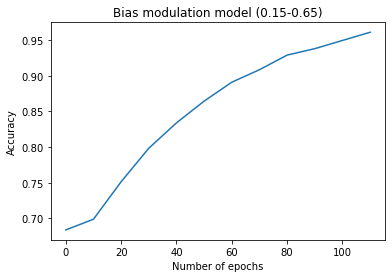

In [11]:
fig = plt.figure()
plt.plot(np.arange(0,int(N_epoch_t/10 +2))*10,acc_mean)
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.title('Bias modulation model (0.15-0.65)')
# plt.savefig(fname = 'Accuracy of Bias model (0.15-0.65).jpg', transparent = True, bbox_inches = 'tight', dpi = 100)
plt.show()


In [12]:
# bias_mean[0:3] = bias_mean[4:7]

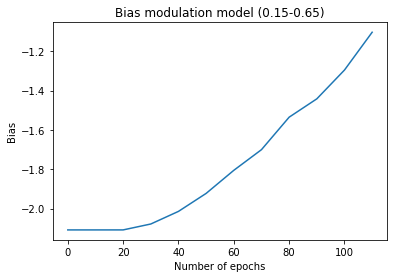

In [13]:
fig = plt.figure()
plt.plot(np.arange(0,int(N_epoch_t/10 +2))*10,bias_mean)
plt.ylabel('Bias')
plt.xlabel('Number of epochs')
plt.title('Bias modulation model (0.15-0.65)')
# plt.savefig(fname = 'Bias of Bias model (0.15-0.65).jpg', transparent = True, bbox_inches = 'tight', dpi = 100)
plt.show()


In [14]:
a1 = np.mean(all_accuracy1)
a2 = np.mean(all_accuracy2)
cal_b1 = np.mean(all_cal_biases1)
cal_b2 = np.mean(all_cal_biases2)
b1 = torch.mean(all_biases1)
b2 = torch.mean(all_biases2)
print(a1)
print(a2)
print(cal_b1)
print(cal_b2)
print(b1)
print(b2)

0.684
0.961
-2.1089422939606988
-1.1026531249418756
tensor(-0.3660, grad_fn=<MeanBackward0>)
tensor(-0.1444, grad_fn=<MeanBackward0>)


In [15]:
conf1[0,1]+ conf1[1,1]

1000.0